In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
#output_folder = "recommendations"
output_folder = "data/daily"

os.makedirs(output_folder, exist_ok=True)

In [2]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [3]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [4]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {scrId}: {e}")

In [5]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [6]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 16
Most Active: 84
Trending: 19
Total unique hot symbols: 109


In [7]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [8]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [9]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251118163752.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
0,DGNX,15.0841,10.994110,1251796.0,767879.0,3.062153e+09,1.630200,1.000000,0.967742,0.709677,0.903226,0.920968
1,AS,33.0335,7.391093,5704999.0,5230676.0,1.831944e+10,1.090681,0.989247,0.956989,0.774194,0.763441,0.912366
7,MDT,100.6900,4.578968,7441771.0,6931262.0,1.291466e+11,1.073653,0.913978,0.946237,0.849462,0.870968,0.908065
6,MSTR,205.2700,5.040429,6375768.0,12046590.0,5.898510e+10,0.529259,0.935484,0.817204,0.924731,0.892473,0.887634
14,JAZZ,175.5050,3.183614,743704.0,825357.0,1.066458e+10,0.901069,0.827957,0.913978,0.881720,0.989247,0.884946
8,MRK,96.9650,4.420629,9950226.0,12297668.0,2.421975e+11,0.809115,0.903226,0.892473,0.817204,0.795699,0.871505
17,LNW,86.2200,0.000000,38854866.0,1955942.0,7.028989e+09,19.865040,0.629032,1.000000,1.000000,0.967742,0.866935
13,BLTE,121.1100,3.592504,33053.0,67032.0,4.225648e+09,0.493093,0.870968,0.795699,0.838710,1.000000,0.851075
4,HTFL,28.1474,6.618940,174226.0,388740.0,2.396997e+09,0.448181,0.956989,0.752688,0.741935,0.978495,0.844624
9,TERN,26.6250,4.166669,1531871.0,2393689.0,2.398374e+09,0.639962,0.892473,0.860215,0.655914,0.838710,0.828495


In [10]:
top50['symbol']

0      DGNX
1        AS
7       MDT
6      MSTR
14     JAZZ
8       MRK
17      LNW
13     BLTE
4      HTFL
9      TERN
98       XP
81     AXTA
12      FCX
15     TCOM
3       JHX
71     CRCL
2      ONDS
33     BMNR
24     MTSR
20     QUBT
59       FI
39     IREN
58        B
65     META
30    GOOGL
49     NFLX
60     GOOG
66      SMR
74     SNDK
11       GT
57      PDD
53     MSFT
5      SRRK
10     WULF
41       MU
91     XPEV
83      OWL
26     AMZN
79     IONQ
80     NBIS
84      NVO
43     KVUE
16     NVDA
93     CSCO
21     TSLA
48     HOOD
28      AMD
42     AAPL
46     CRWV
29     PLTR
Name: symbol, dtype: object

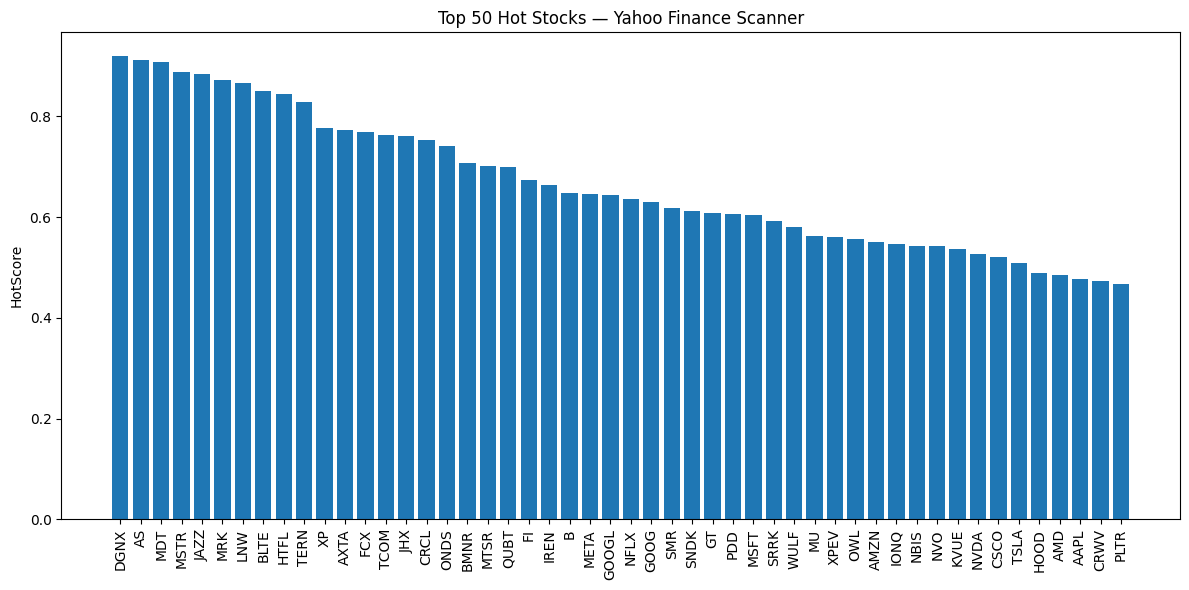

In [11]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()